# CEWA 568 - Snow Hydrology 
# Homework 2
# Daniel Hogan

In [1]:
import pandas as pd
import urllib
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import datetime as dt
import requests
import geopandas as gpd

# Problem 1
Using the observations of total precipitation and the snow pillow data (see labs above), we are going to investigate the mass balance and snow accumulation at Kettle Ponds.

## A. Plot a timeseries of total accumulated precipitation and total accumulated snow water equivalent from the four snow pillows. Add to your plot timeseries from the two Snotel Stations located nearby. Discuss how they match and how they differ, and why you think they differ.

### Download Snotel Data

In [2]:
# Build a dictionary with the names and station triplet ids
east_river_sntl_dict = {'Butte':'380:CO:SNTL',
                        'Schofield Pass': '737:CO:SNTL'}
site_ids = list(east_river_sntl_dict.values())

In [5]:
# API Domain name
API_DOMAIN = "https://wcc.sc.egov.usda.gov/awdbRestApi/swagger-ui.html#/"
def get_awdb_data(
    site_ids,
    elements=["TAVG","SNWD","WTEQ"],
    sdate=datetime(1899, 10, 1),
    edate=dt.datetime.today() - dt.timedelta(days=1),
    orient="records",
    server=API_DOMAIN,
    sesh=None,
):
    """
    Takes a list of site ids or a single site id and by default returns SWE period of record data as a single or list of dataframes,
    but user can pass args to modify data returned.
    Valid elements include WTEQ, SNWD, TAVG
    site_id takes the form of a triplet made from <network_site_id>:<state_abbrv>:<network> where network is either SNTL or MNST
    """
    # Create an emply list to hold the dataframe output
    dfs = []
    # Incase only one site id is passed as a string, this will put it in a list
    return_single = False
    if not isinstance(site_ids, list):
        site_ids = [site_ids]
        return_single = True
    # Iterate over the site ids
    for site_id in site_ids:
        # Iterate over each of the elements (TAVG, WTEQ, SNWD)
        for element in elements:
            # this determines what data we will grab, daily data in this case
            endpoint = "data/getDaily"
            # This next few lines builds the API request
            date_args = f"sDate={sdate:%Y-%m-%d}&eDate={edate:%Y-%m-%d}"
            frmt_args = f"format=json&orient={orient}"
            all_args = f"?triplet={site_id}&{date_args}&element={element}&{frmt_args}"
            url = f"{server}{endpoint}{all_args}"
            # This prints output to tell us what we are working on building
            print(
                f"getting data for {site_id} {element} starting {sdate:%Y-%m-%d} "
                f"and ending {edate:%Y-%m-%d}"
            )
            # This builds the column names
            data_col_lbl = f"{element}"
            # This makes the actual API requests
            if sesh:
                req = sesh.get(url)
            else:
                req = requests.get(url)
            if req.ok:
                df = pd.DataFrame.from_dict(req.json())
                df.columns = [data_col_lbl,"Date"]
                df.set_index("Date", inplace=True)
            else:
                print("  No data returned!")
                df = (
                    pd.DataFrame(
                        data=[{"Date": pd.NaT, data_col_lbl: np.nan}],
                    )
                    .set_index("Date")
                    .dropna()
                )
            # Append the dataframe that was built and return
            dfs.append(df)
        if return_single:
            return dfs[0]
    return dfs

# Grab dataframes that we want, can add other desired inputs to the function if a shorter time period is desired
sntl_dfs = get_awdb_data(site_ids=site_ids)

# Make the index a datetime
for i,df in enumerate(sntl_dfs):
    df.index = pd.to_datetime(df.index)
    sntl_dfs[i] = df

# create a dictionary for conversion to xarray
sntl_df_dict = {
    site_ids[0]:pd.concat(sntl_dfs[0:3], axis=1).sort_index().to_xarray(),
    site_ids[1]:pd.concat(sntl_dfs[3:6], axis=1).sort_index().to_xarray()
    }

getting data for 380:CO:SNTL TAVG starting 1899-10-01 and ending 2023-07-24
  No data returned!
getting data for 380:CO:SNTL SNWD starting 1899-10-01 and ending 2023-07-24
  No data returned!
getting data for 380:CO:SNTL WTEQ starting 1899-10-01 and ending 2023-07-24
  No data returned!
getting data for 737:CO:SNTL TAVG starting 1899-10-01 and ending 2023-07-24
  No data returned!
getting data for 737:CO:SNTL SNWD starting 1899-10-01 and ending 2023-07-24
  No data returned!
getting data for 737:CO:SNTL WTEQ starting 1899-10-01 and ending 2023-07-24
  No data returned!


In [58]:
# convert to xarray
sntl_ds = xr.concat(sntl_df_dict.values(), pd.Index(sntl_df_dict.keys(), name='Location'))
# Add water year variable
sntl_ds = sntl_ds.assign_coords({'WY':sntl_ds.Date.dt.year.where(sntl_ds.Date.dt.month < 10, sntl_ds.Date.dt.year + 1)})

# Unit conversions to centimeters
sntl_ds['SNWD'] = sntl_ds['SNWD']*2.54
sntl_ds['SNWD'] = sntl_ds['SNWD'].assign_attrs({'units':'cm'})

sntl_ds['WTEQ'] = sntl_ds['WTEQ']*2.54
sntl_ds['WTEQ']  = sntl_ds['WTEQ'].assign_attrs({'units':'cm'})

# Unit conversion to degrees Celsius
sntl_ds['TAVG'] =  (sntl_ds['TAVG']-32) * 5/9
sntl_ds['TAVG'] = sntl_ds['TAVG'].assign_attrs({'units':'degC'})

### Download Snow pillow data from SOS site

In [40]:
# Provide the path to a directory you want to download the SoS files to
download_directory = './sosnoqc/'

# Provide the paths to the precipitation file. This file was provided to you, you can either
# specify the path below or put the file in the same directory as this notebook.
precipitation_file = 'precipitation.nc'

# Provide a the start and end dates you want to download
start_date = '20221201'
end_date = '20230411'

# Provide the specific variables you want to extract from the dataset.
# We provide these in advance because the datasets are very large and, 
# when we open them, we want to immediately extract only the data we want.
VARIABLES = [
    'SWE_p1_c',
    'SWE_p2_c',
    'SWE_p3_c',
    'SWE_p4_c',
    'T_2m_c',
]

In [45]:
def download_sos_data_day(date, local_download_dir, cache=True):
    """Download a netcdf file from the ftp url provided by the Earth Observing 
    Laboratory at NCAR. Data comes in one NetCDF file per day, Reynolds-Averaged 
    with a 5-minute averaging period.

    Args:
        date (str, optional): String representing a date in format '%Y%m%d'. Defaults to '20221101'.
        local_download_dir (str, optional): Directory to which files will be downloaded. Defaults 
                    to 'sosnoqc'; this directory will be created if it  does not already exist.
        cache (bool, optional): If True, looks in `local_download_dir` for requested  file, if it 
                    exists, does not redownload file. If False, downloads file from the FTP server.

    Returns:
        _type_: Relative path to the downloaded file
    """
    base_url = f'ftp://ftp.eol.ucar.edu/pub/archive/isfs/projects/SOS/netcdf/noqc_geo/'
    file = f'isfs_{date}.nc'
    os.makedirs(local_download_dir, exist_ok=True)
    full_file_path = base_url+file
    download_file_path = local_download_dir + file
    if cache and os.path.isfile(download_file_path):
        print(f"Caching...skipping download for {date}")
    else:
        urllib.request.urlretrieve(
            full_file_path,
            download_file_path   
        )
    return download_file_path

In [44]:
# Create a list of datetime objects for every day between the provided start_date and end_date. 
datelist = pd.date_range(
    dt.datetime.strptime(start_date, '%Y%m%d'),
    dt.datetime.strptime(end_date, '%Y%m%d'),
    freq='d'
).strftime('%Y%m%d').tolist()

# Download one daily file for each date in the datelist. 
# cache = True so that when we rerun the notebook in the future, we don't have to redownload the data.
files = [download_sos_data_day(date, download_directory, cache=True) for date in datelist]

ftp://ftp.eol.ucar.edu/pub/archive/isfs/projects/SOS/netcdf/noqc_geo/isfs_20221201.nc
Caching...skipping download for 20221201
ftp://ftp.eol.ucar.edu/pub/archive/isfs/projects/SOS/netcdf/noqc_geo/isfs_20221202.nc
Caching...skipping download for 20221202
ftp://ftp.eol.ucar.edu/pub/archive/isfs/projects/SOS/netcdf/noqc_geo/isfs_20221203.nc
Caching...skipping download for 20221203
ftp://ftp.eol.ucar.edu/pub/archive/isfs/projects/SOS/netcdf/noqc_geo/isfs_20221204.nc
Caching...skipping download for 20221204
ftp://ftp.eol.ucar.edu/pub/archive/isfs/projects/SOS/netcdf/noqc_geo/isfs_20221205.nc
Caching...skipping download for 20221205
ftp://ftp.eol.ucar.edu/pub/archive/isfs/projects/SOS/netcdf/noqc_geo/isfs_20221206.nc
Caching...skipping download for 20221206
ftp://ftp.eol.ucar.edu/pub/archive/isfs/projects/SOS/netcdf/noqc_geo/isfs_20221207.nc
Caching...skipping download for 20221207
ftp://ftp.eol.ucar.edu/pub/archive/isfs/projects/SOS/netcdf/noqc_geo/isfs_20221208.nc
Caching...skipping downlo

In [47]:
# Open up datasets from every day, extracting our VARIABLES of choice as we open individual datasets. This is so that we have a smaller dataset held 
# in computer memory.
all_datasets = [xr.open_dataset(file)[VARIABLES] for file in files]
sos_dataset = xr.concat(all_datasets, dim='time')

In [62]:
# Download precip data
accum_precip = xr.open_dataset('./precipitation.nc')/10

In [64]:
accum_precip

<xarray.Dataset>
Dimensions:   (date: 132)
Coordinates:
  * date      (date) datetime64[ns] 2022-11-01 2022-11-02 ... 2023-03-12
Data variables:
    acc_prec  (date) float64 0.0 0.0 1.09 1.09 1.111 ... 34.4 38.8 40.34 41.2

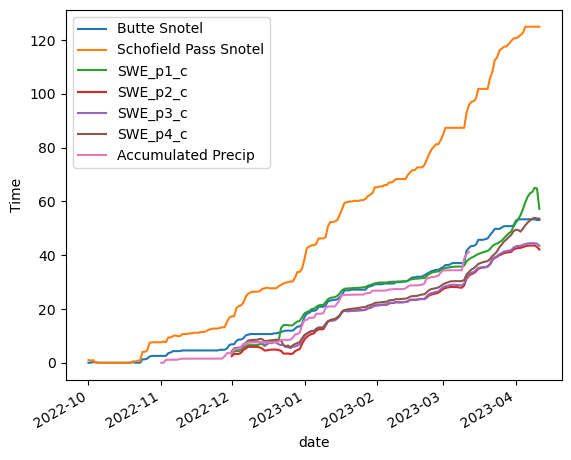

In [65]:
# Create SWE plot
fig, ax = plt.subplots()

sntl_ds.sel(Location='380:CO:SNTL', Date=slice('20221001','20230411'))['WTEQ'].plot(ax=ax, label='Butte Snotel')
sntl_ds.sel(Location='737:CO:SNTL', Date=slice('20221001','20230411'))['WTEQ'].plot(ax=ax, label='Schofield Pass Snotel')

for variable in VARIABLES[0:-1]:
    (sos_dataset[variable].resample(time='1D').max()/10).plot(ax=ax, label=variable)

accum_precip['acc_prec'].plot(ax=ax, label='Accumulated Precip')
ax.set_ylabel('SWE (cm)')
ax.set_ylabel('Time')
ax.legend()


The most apparent difference is the difference between Butte and the 4 SOS pillows and Schofield Pass. Schofield Pass is located up the valley and at a higher elevation which allows it to receive more snowfall. In addition it lies at the passage between northwest facing mountains and a more western drainage, which receive more total snowfall over the year. The second most apparent difference is the higher accumulated precipitation vs measured pillow SWE at the site. Accumulated precipitation is higher than SWE most likely due to transport of snow from most of the pillows that then either is deposited in drifts or sublimated away. The third difference that is most apparent is between pillow 1 and the other snow pillows. This difference is mostly due to differences in localized terrain. Pillow 1 is situated in a depression at the site and thus built up more snow during the early season, most notably during a large wind event that deposited lots of snow into that depression. Most of these terrain driven differences were balanced out later in the snow year until the most recent set of storms, which may have had drifting play a role again. Differences between the pillows and Butte are most likely due to just being in fundamentally different locations. Butte is located in a clearing in the trees, wheras Kettle Ponds is in the open. Additionally, the Butte site is on a northeast facing aspect, wheras Kettle Ponds slopes slightly to the southwest. 

## B. 
Write out the snow mass balance equation for a control volume. Given the data you have plotted, what aspects of the mass balance equation do you have the most certainty about? The least certainty?

$$\frac{dSWE}{dt} = \rho_{bulk} Snowfall - Melt - Sublimation \pm Redistribution $$

The snow mass balance relates the change in SWE over time to the bulk SWE from snowfall minus melt and sublimation and plus or minus any redistribution from wind. I would say with our data, we have decent agreement for the term on the LHS of the equation and the first term of the RHS. Decreases in SWE are difficult to relate directly to the loss terms and to redistribution, but signals of redistribution should occur most with strong wind events so if we had an understanding for what the winds were, that may be able to provide some confidence in when snow was redistributed. 

## C. 
What factors of the mass balance are the most similar spatially? Which differ the most across different locations? Is there more variability between sites further away? Or are the four snow pillows at Kettle Ponds as different as the two sites just outside of the watershed?

The snow mass balance can differ widely in space for all variables that make it up, but depending on the scale being considered, vegetation nearby, and the elevations one is looking across, snowfall, melt, and sublimation are probably the most consistent when looking at sites close to one another (assuming we are not looking at a ridgeline). For example, Butte and the snow pillows at Kettle Ponds are at similar elevations and relatively close to one another. They exhibit similar magnitudes of SWE built up over the year. On the other hand, Schofield Pass has significantly more snow water equivalent accumulated and is located a bit further away and has different location characteristics that with higher precipitation. Melt is trickier to pull out but one would assume that if a location is similar spatially (clear, at a similar elevation), it will be receiving similar amounts of energy to power the melting process. This would be similar to sublimation as well. I left wind redistribtuion out because it can be significantly impacted by more local features, like the Pillow 1 loading we saw early in the season and the aspect of the location (whether or not it is sheltered from prevailing winds.)
Overall, the four snow pillows at Kettle Ponds are similar to one another in their response to snow fall events and generally in their accumulation of SWE over the year. 


## D. 
Prediction NCAR's EOL team is committed to removing the towers at Kettle Ponds on 1 June 2023. To do that, they need to drive down a road (shown in the map above) that is currently snowed in. The road will open when the snow melts and disappears. This typically occurs in mid to late May. Using the long term records at the SNOTEL sites, and any other information you may have, to make a prediction about whether the snow will be gone (and hence the road clear) by 1 June 2023. (Note that we will assess everyone's accuracy at the end of the quarter!)

Given that our snow pillows follow the Butte snotel rather well and the road lies between the KP snow pillows and Butte, I'm only going to use Butte for this estimate. First I'm going to see when what snow water equivalent looked like over previous years and find the few years with the most similar SWE to the current measurement on April 11. Then I'm going to look to see what the melt date for those years was by getting the first index where SWE was 0 for the year (there are better, more robust ways to do this, but I opted for this quick approach). I will compare what the profile of SWE looked like over the year to each of those years with similar SWE and take into account upcoming or recent weather events to come to a guess.

1) Find years with closest SWE for April 1

In [102]:
current_swe_compare = sntl_ds['WTEQ'].sel(Location='380:CO:SNTL').where((sntl_ds.Date.dt.month==4) & (sntl_ds.Date.dt.day==11)).to_dataframe().dropna()
np.abs(current_swe_compare['WTEQ'] - current_swe_compare.iloc[-1]['WTEQ']).sort_values().iloc[0:6]


Date
2023-04-11    0.000
1997-04-11    0.000
1995-04-11    0.508
2017-04-11    0.762
1982-04-11    2.286
1984-04-11    2.794
Name: WTEQ, dtype: float64

In [115]:
# Function to get the day of Water Year
def date2DOWY(day_of_interest):
    day_of_interest = pd.to_datetime(day_of_interest)
    if day_of_interest >= dt.datetime(day_of_interest.year,10,1):
        dowy_start = dt.datetime(day_of_interest.year,10,1)
    else: 
        dowy_start = dt.datetime(day_of_interest.year-1,10,1)
    dowy = day_of_interest - dowy_start
    return dowy.days
# Create an empty array with the same length as the day of water year
dowy = np.zeros(len(sntl_ds.Date.values))
for i,date in enumerate(sntl_ds.Date.values):
    dowy[i] = date2DOWY(date)
# Add this to our dataset
sntl_ds = sntl_ds.assign_coords({'dowy':('Date',dowy)})

2) Look at what these years have in common with 2023

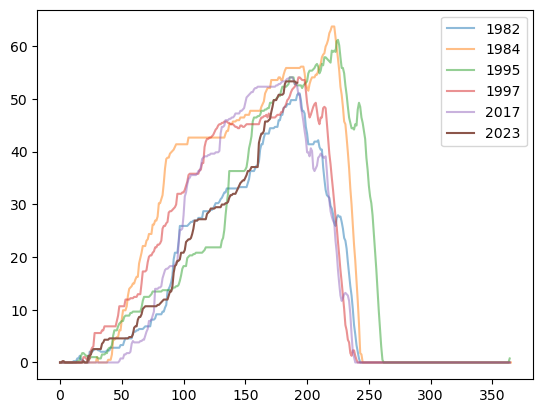

In [126]:
for simyear in [1982,1984,1995,1997,2017,2023]:
    if simyear != 2023:
        alpha=0.5
    else: alpha=1
    plt.plot(sntl_ds.sel(Location='380:CO:SNTL').where(sntl_ds['WY']==simyear)['dowy'], sntl_ds['WTEQ'].sel(Location='380:CO:SNTL').where(sntl_ds['WY']==simyear), label=simyear, alpha=alpha)
plt.legend()
plt.title('SWE over similar years to 2023')

It looks like 1982 and 1997 have similar shapes, but we may 

3) Then I'll calculate the day of first 0 SWE for each of those years

In [109]:
wteq_melt = sntl_ds['WTEQ'].sel(Location='380:CO:SNTL').where((sntl_ds.Date.dt.month>=4) & (sntl_ds.Date.dt.month<7)).to_dataframe().dropna()
melt_date = wteq_melt.groupby(wteq_melt.index.year).idxmin()
melt_date[melt_date.index.isin([1997,1995,2017,1982,1984])]

,WY,WTEQ
Date,,
1982,1982-04-01,1982-06-01
1984,1984-04-01,1984-06-02
1995,1995-04-01,1995-06-20
1997,1997-04-01,1997-05-30
2017,2017-04-01,2017-05-28


Looks like these mostly fall around the end of May to early June.
Initially, I would guess around this time, but recently the area has seen a large dust-on-snow event which has accellerated melt with record warm temperatures. These will be modulated by this weekend however, as small shots of snow return. I do think we have hit peak SWE, so I don't think we'll see something like 1995. With more dust-on-snow events likely in the next month and near- to warmer- than normal signals forecasted in the climatology, I think melt out will be on the quicker side and snow will clear by May 25, a few days earlier than these similar years. 


# Problem 2: Course Project Selection
Write a brief paragraph (3-9 sentences) describing your term project. Include the name of your partner (or specify you will be doing the project alone), the concept you will communicate or teach, and the tools you will use. If you have questions about the project, now is the time to talk to the instructor.

I plan to do this project alone and process our snow pit data from Kettle Ponds to create a series of notebooks to look at snowpit data and compare measurements to other measurements of surface temperature, snow water equivalent, and snowpack temeprature taken at the site. Additionally, i'd like to compare depth estimates we measured to depths using the measured density and SWE at the site. I'm hoping to build a notebook that could be run and shared for the class prior to going on the field trip to Snoqualamie. Ideally, I would make a slideshow to introduce what a snowpit is, why they are dug, what and how measurements are taken. Then I would build interactive notebooks to compare the data to other observations as discussed above. This could also be used to introduce some field topics to different interested groups.